In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from plottable import Table
from plottable import ColumnDefinition
from matplotlib import rc
from matplotlib.cm import Greens, Reds
from plottable.formatters import decimal_to_percent
import matplotlib.cm as cm
import seaborn as sns


## Utils

In [4]:
import random
def generate_colors(num_colors):
    # Get the YGnBu colormap
    cmap = cm.get_cmap('summer')

    # Generate 10 equally spaced values between 0 and 1
    values = np.linspace(0, 1, num_colors)

    # Get the colors from the colormap
    colors = [cmap(value) for value in values]
    return colors

In [5]:
def draw_stacked_bars(dataframe: pd.DataFrame, colors = ['red', 'blue', 'green', 'yellow', 'oranges', 'pink']):
    columns = dataframe.columns
    colors = generate_colors(len(columns))
    r = list(range(len(columns)))

    # From raw value to percentage
    all_bars = []
    max_bar_length = 0
    for col in columns:
        model_total = len(dataframe[col])
        bars = np.array([(dataframe[col] == x).sum() for x in dataframe[col].unique()]) / model_total
        all_bars.append(bars.tolist())
        if len(bars) > max_bar_length:
            max_bar_length = len(bars)
    
    # fill other with zero
    for i, bars in enumerate(all_bars):
        reminder = max_bar_length - len(bars)
        all_bars[i] = bars + [0 for r in range(reminder)]
    all_bars = np.array(all_bars)

    # plot
    barWidth = 0.85

    # Create green Bars
    last_bar_items = np.zeros((all_bars.shape[0]))
    for i, bar_items in enumerate(all_bars.T):
        plt.bar(
            r,
            bar_items,
            bottom=last_bar_items,
            color=colors[i],
            edgecolor='white', width=barWidth)
        
        for j, item in enumerate(bar_items):
            if item > 0.01:
                print()
                plt.text(j, (last_bar_items[j] + item / 2), dataframe.iloc[:, j].unique()[i], horizontalalignment='center', size='small', color='black')
        
        last_bar_items += bar_items

    # Custom x axis
    plt.xticks(r, columns)
    plt.xlabel("group")
    plt.title("Best AUC result component contribution")
    # Show graphic
    plt.show()

## Best AUC result component contribution

In [6]:
all_models=["resnet18", "resnet34", "xception"]
all_datasets=['cifar10']
all_optim = ['adam', 'sgd', 'rmsprobe', 'sparseadam']
all_initialization = ['pretrain', 'kaiming_normal']
all_lr_scheduler = ['reduceLR', 'none', 'cosine_annealingLR']
all_noise_injection = ["0.0", "0.03", "0.07", "0.13"]
all_noise_sparsity = ["0.0", "0.2", "0.4", "0.6"]
all_lr_rate = ['0.001', '0.1']
all_folds = ['0', '1', '2']
all_phase = ['train', 'validation']
all_epochs = 5
device = 'cuda:0'
all_metrics = ['correctness', 'integral_diff_proba_2max']

In [7]:
metrics_info_dataset = pd.DataFrame()
for metric in all_metrics:
    metrics_info_path = f"/home/vision/Repo/cleanset/logs/metrics/{metric}.csv"
    metrics_info = pd.read_csv(metrics_info_path, index_col='index')
    metrics_info['metric'] = metric
    metrics_info_dataset = metrics_info_dataset._append(metrics_info, ignore_index=True)

metrics_info_dataset['metric'] = metrics_info_dataset['metric'].replace(['integral_diff_proba_2max'], 'diff_2max')

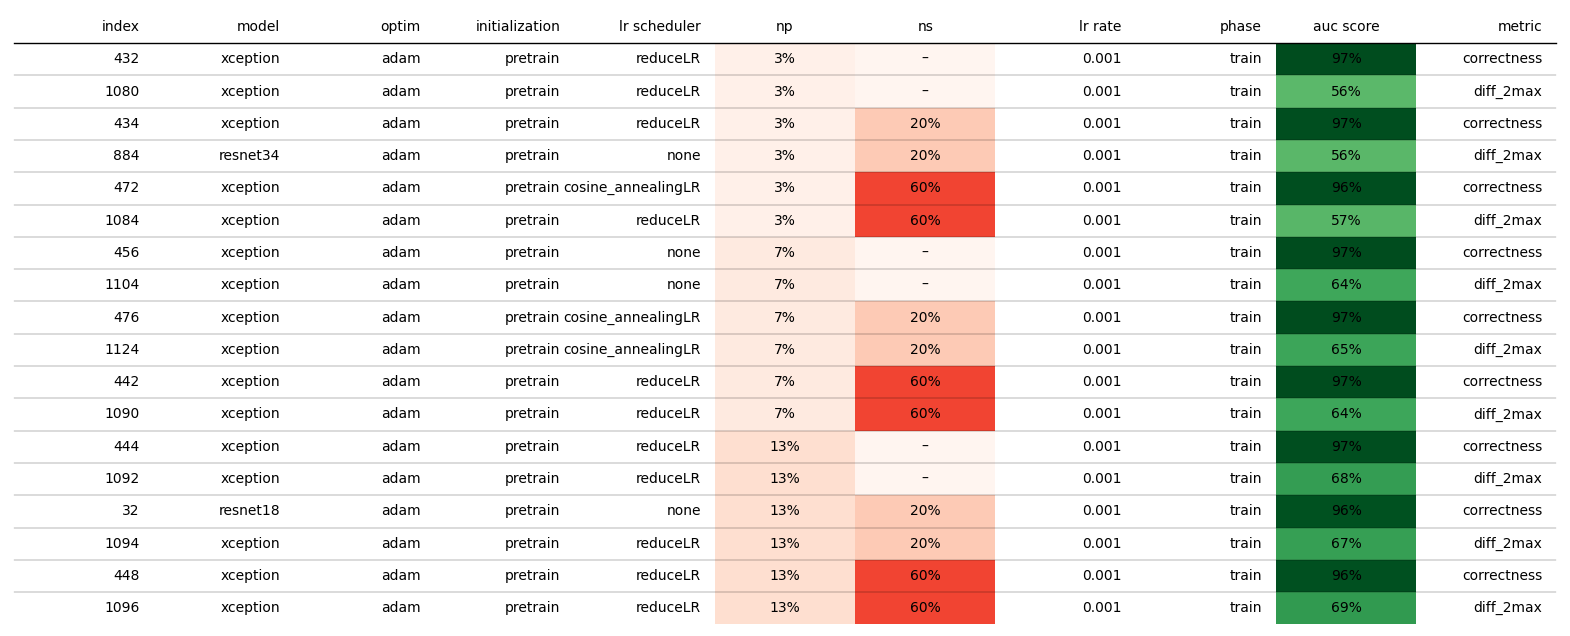

In [8]:
max_auc_rows = metrics_info_dataset.loc[metrics_info_dataset.groupby(['np', 'ns', 'metric'])['auc score'].idxmax()]

# Init a figure
fig, ax = plt.subplots(figsize=(20, 8))

# Create the Table() object
tab = Table(max_auc_rows, column_definitions=[
    ColumnDefinition(name="auc score", cmap=Greens, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="np", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="ns", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()

In [ ]:
dataframe = max_auc_rows[['model', 'optim', 'initialization', 'lr scheduler']]
dataframe['lr scheduler'].replace({'cosine_annealingLR': 'cosALR'}, inplace=True)
draw_stacked_bars(dataframe)

## Configurations impact on AUC

In [77]:
metrics_info_dataset.head()

,model,optim,initialization,lr scheduler,np,ns,lr rate,phase,metric,auc score
0,resnet18,adam,pretrain,reduceLR,0.03,0.0,0.001,train,correctness,0.968340
1,resnet18,adam,pretrain,reduceLR,0.03,0.0,0.001,validation,correctness,0.942719
2,resnet18,adam,pretrain,reduceLR,0.03,0.2,0.001,train,correctness,0.962012
3,resnet18,adam,pretrain,reduceLR,0.03,0.2,0.001,validation,correctness,0.937638
4,resnet18,adam,pretrain,reduceLR,0.03,0.6,0.001,train,correctness,0.955281


In [128]:
x = metrics_info_dataset.pop('auc score')
metrics_info_dataset[x.name] = x.values

columns = list(metrics_info_dataset.columns)

df = pd.DataFrame()
for target_column in list(metrics_info_dataset.columns):
    if target_column in ["auc score", "metric", "ns", "np", 'lr rate']:
        continue
    columns = list(metrics_info_dataset.columns)
    columns.remove(target_column)
    columns.remove('auc score')
    aggregation_resuslt = metrics_info_dataset.groupby(columns)['auc score'].aggregate(['max', 'min']).reset_index()
    aggregation_resuslt[f'diff'] = (aggregation_resuslt['max'] - aggregation_resuslt['min'])
    aggregation_resuslt['setting'] = target_column 

    df = df._append(aggregation_resuslt[['diff', 'setting']], ignore_index=True)

<Axes: xlabel='setting', ylabel='diff'>

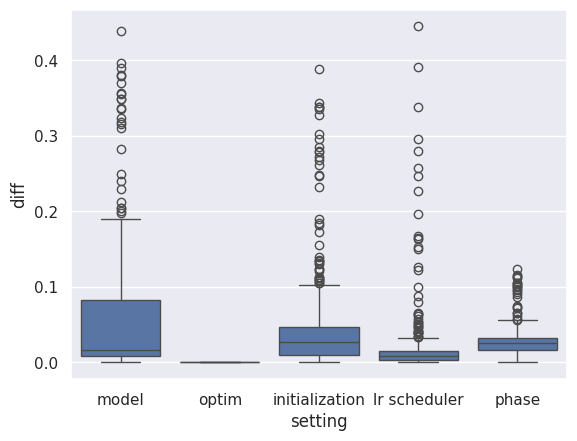

In [129]:
sns.boxplot(y=df["diff"], x=df["setting"])